## Model:
- using VGG16 as base model (transfer learning) with pre-trained weights of imagenet
- fine tuning layers from fully connected layers
- using Augmented Data

In [31]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [32]:
print(os.listdir('../input/skindisease/SampleData'))

['Chickenpox', 'Cellulitis', 'Allergic Eczema']


In [33]:
folder_AllergicEczema = '../input/skindisease/SampleData/Allergic Eczema'
folder_ChickenPox = '../input/skindisease/SampleData/Chickenpox'
folder_Cellulitis = '../input/skindisease/SampleData/Cellulitis'

folders = [folder_AllergicEczema, folder_ChickenPox, folder_Cellulitis]

In [34]:
def read_image(folder_name):
    temp_data = []
    for file in tqdm(os.listdir(folder_name)):
        try:
            temp_data.append(plt.imread(folder_name+'/'+file))
        except:
            pass
    return temp_data

data_AllergicEczema = read_image(folder_AllergicEczema)
data_ChickenPox = read_image(folder_ChickenPox)
data_Cellulitis = read_image(folder_Cellulitis)

    

100%|██████████| 288/288 [00:08<00:00, 33.30it/s]


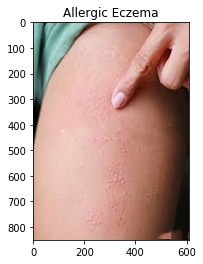

In [35]:
plt.title('Allergic Eczema')
plt.imshow(data_AllergicEczema[0])

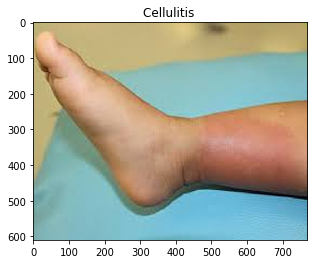

In [36]:
plt.title('Cellulitis ')
plt.imshow(data_Cellulitis[10])

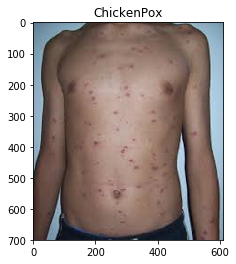

In [37]:
plt.title('ChickenPox')
plt.imshow(data_ChickenPox[0])

In [38]:
## finding the minimum dimension for the image

min_dim = [2000,2000]

for img in data_AllergicEczema:
    if img.shape[0] < min_dim[0]:
        min_dim[0] = img.shape[0]
    if img.shape[1] < min_dim[1]:
        min_dim[1] = img.shape[1]
        
for img in data_Cellulitis:
    if img.shape[0] < min_dim[0]:
        min_dim[0] = img.shape[0]
    if img.shape[1] < min_dim[1]:
        min_dim[1] = img.shape[1]
        
for img in data_ChickenPox:
    if img.shape[0] < min_dim[0]:
        min_dim[0] = img.shape[0]
    if img.shape[1] < min_dim[1]:
        min_dim[1] = img.shape[1]
        
print(min_dim)

[168, 160]


In [39]:
image_height = 224
image_width = 224
n_channels = 3
image_input = Input(shape=(224, 224, 3))

In [40]:
## resizing entire image into same dimension and adding a label column:
## 0 - AllergicEczema
## 1 - ChickenPox
## 2 - Cellulitis

def resize_and_Label_Image(data_image, label):
    resized_labeled_image = []
    for img in tqdm(data_image):
        resized_labeled_image.append([cv2.resize(img, (image_height,image_width)), label])
    return resized_labeled_image

data_resized_AllergicEczema = resize_and_Label_Image(data_AllergicEczema, 0)
data_resized_ChickenPox = resize_and_Label_Image(data_ChickenPox, 1)
data_resized_Cellulitis = resize_and_Label_Image(data_Cellulitis, 2)

100%|██████████| 145/145 [00:00<00:00, 1705.13it/s]


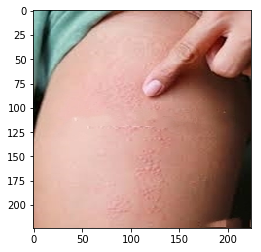

In [41]:
plt.imshow(data_resized_AllergicEczema[0][0])

In [42]:
print("#####ABOUT DATA######\n")
print("Images under Allergic Eczema")
print("Total Data: ", len(data_resized_AllergicEczema))
print("Shape: ", data_resized_AllergicEczema[0][0].shape)
print('\n')
print("Images under Chicken Pox")
print("Total Data: ", len(data_resized_ChickenPox))
print("Shape: ", data_resized_ChickenPox[0][0].shape)
print('\n')
print("Images under Cellulitis")
print("Total Data: ", len(data_resized_Cellulitis))
print("Shape: ", data_resized_Cellulitis[0][0].shape)

#####ABOUT DATA######

Images under Allergic Eczema
Total Data:  273
Shape:  (224, 224, 3)


Images under Chicken Pox
Total Data:  141
Shape:  (224, 224, 3)


Images under Cellulitis
Total Data:  145
Shape:  (224, 224, 3)


In [43]:
## append all images into one list and then shuffle the images
data_images = data_resized_AllergicEczema + data_resized_ChickenPox + data_resized_Cellulitis
random.shuffle(data_images)

In [44]:
len(data_images)

559

In [45]:
## After shuffle - will separate features and labels
X = []
y = []

for feature, label in data_images:
    X.append(feature)
    y.append(label)

In [46]:
print("images & labels sizes: ", (len(X), len(y)))

images & labels sizes:  (559, 559)


In [47]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2, stratify=y)

In [48]:
## one hot encoding for y_labels for train data

y_train_oneHotEncoding = to_categorical(train_y)
print('Train_data Shape: ', y_train_oneHotEncoding.shape)

## one hot encoding for y_labels for test data

y_test_oneHotEncoding = to_categorical(test_y)
print('Test_data Shape: ', y_test_oneHotEncoding.shape)

Train_data Shape:  (447, 3)
Test_data Shape:  (112, 3)


In [49]:
## array reshape and normalizing
train_X = np.array(train_X)
train_X = train_X/255
test_X = np.array(test_X)
test_X = test_X/255

## VGG-16 Model with Top included

In [50]:
## using imagenet weights and use VGG16 as base model

base_model=VGG16(weights='imagenet',include_top=True, input_shape=(image_height, image_width, n_channels)) # excluding the top fully connected layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [51]:
last_layer=base_model.get_layer('fc2').output
prediction=Dense(3,activation='softmax', name='prediction')(last_layer) #final layer with softmax activation

In [52]:
model=Model(inputs=base_model.input,outputs=prediction)

In [53]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [54]:
len(model.layers)

23

In [55]:
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

In [56]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history=model.fit(train_X,y_train_oneHotEncoding,batch_size=128,epochs=20,validation_split=0.2)

In [63]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

In [69]:
train_generator = train_datagen.flow(train_X, y_train_oneHotEncoding, batch_size=32)
validation_generator = train_datagen.flow(train_X, y_train_oneHotEncoding, batch_size=32)

model.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/50
14/14 [==============================] - 10s 694ms/step - loss: 0.2889 - accuracy: 0.8792 - val_loss: 0.1226 - val_accuracy: 0.8837
Epoch 2/50
14/14 [==============================] - 9s 614ms/step - loss: 0.2496 - accuracy: 0.8971 - val_loss: 0.2544 - val_accuracy: 0.9239
Epoch 3/50
14/14 [==============================] - 9s 621ms/step - loss: 0.2385 - accuracy: 0.9038 - val_loss: 0.2292 - val_accuracy: 0.9374
Epoch 4/50
14/14 [==============================] - 9s 615ms/step - loss: 0.2328 - accuracy: 0.8949 - val_loss: 0.3450 - val_accuracy: 0.8412
Epoch 5/50
14/14 [==============================] - 9s 627ms/step - loss: 0.3108 - accuracy: 0.8792 - val_loss: 0.1870 - val_accuracy: 0.8993
Epoch 6/50
14/14 [==============================] - 9s 615ms/step - loss: 0.2488 - accuracy: 0.8926 - val_loss: 0.1396 - val_accuracy: 0.9083
Epoch 7/50
14/14 [==============================] - 9s 615ms/step - loss: 0.2142 - accuracy: 0.9351 - val_loss: 0.2903 - val_accuracy: 0.8613
Epoch

In [ ]:
##epoch = 3
##model.fit_generator(datagen.flow(train_X, y_train_oneHotEncoding, batch_size=32, subset='validation'), steps_per_epoch=len(train_X) / 32, epochs=epoch)

In [70]:
test_loss,test_acc=model.evaluate(test_X,y_test_oneHotEncoding)
test_loss,test_acc

112/112 [==============================] - 1s 7ms/step


(1.2529761110033308, 0.7232142686843872)

In [71]:
prediction_prob = model.predict(test_X)
predicted_labels = prediction_prob.argmax(axis=-1)

In [72]:
confusion_matrix(test_y, predicted_labels)

array([[40,  6,  9],
       [ 6, 18,  4],
       [ 6,  0, 23]])

In [73]:
target_names = ['Allergic Eczema', 'Chicken Pox', 'Cellulitis']
print(classification_report(test_y, predicted_labels, target_names=target_names))

                 precision    recall  f1-score   support

Allergic Eczema       0.77      0.73      0.75        55
    Chicken Pox       0.75      0.64      0.69        28
     Cellulitis       0.64      0.79      0.71        29

       accuracy                           0.72       112
      macro avg       0.72      0.72      0.72       112
   weighted avg       0.73      0.72      0.72       112

